<a href="https://colab.research.google.com/github/Rafiquekuwari/CODESOFT/blob/main/task5_Face_Recognition_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install insightface==0.7.3 opencv-python numpy onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1057642 sha256=1922356937144a3a07fb3dcf4d7d53505c02a7270f244143473afff10be58c49
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface


In [ ]:
# Import libraries
import insightface
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Initialize ArcFace model
model = insightface.app.FaceAnalysis(name='buffalo_l')  # High-accuracy model
model.prepare(ctx_id=-1)  # Use GPU

print("Model initialized successfully.")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 100874.92KB/s]
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Model initia

In [ ]:
def load_known_faces_from_dataset(dataset_dir):
    """Load face embeddings from dataset/train/<person_name> directories."""
    known_embeddings = []
    known_names = []

    for person_name in os.listdir(dataset_dir):
        person_folder = os.path.join(dataset_dir, person_name)
        if not os.path.isdir(person_folder):
            continue

        embeddings = []

        for filename in os.listdir(person_folder):
            if filename.endswith(('.jpg', '.png')):
                image_path = os.path.join(person_folder, filename)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error loading {filename}")
                    continue
                faces = model.get(image)

                if faces:
                    embeddings.append(faces[0].embedding)
                else:
                    print(f"No face detected in {filename} of {person_name}")

        if embeddings:
            mean_embedding = np.mean(embeddings, axis=0)
            known_embeddings.append(mean_embedding)
            known_names.append(person_name)
        else:
            print(f"No valid face embeddings found for {person_name}")

    return known_embeddings, known_names

def recognize_faces_image(test_image_path, known_embeddings, known_names, output_path='output_arcface.jpg'):
    """Recognize faces in a single image."""
    test_image = cv2.imread(test_image_path)
    if test_image is None:
        print("Error: Could not load test image")
        return

    faces = model.get(test_image)

    for face in faces:
        test_embedding = face.embedding
        bbox = face.bbox.astype(int)

        # Compute cosine similarity with known embeddings
        similarities = [
            np.dot(test_embedding, known_emb) / (np.linalg.norm(test_embedding) * np.linalg.norm(known_emb))
            for known_emb in known_embeddings
        ]

        max_similarity = max(similarities) if similarities else 0
        if max_similarity > 0.5:
            best_match_index = np.argmax(similarities)
            name = known_names[best_match_index]
        else:
            name = "Unknown"

        cv2.rectangle(test_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(test_image, name, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Save and display result
    cv2.imwrite(output_path, test_image)
    cv2_imshow(test_image)
    print(f"Output saved as {output_path}")

print("Helper functions ready.")


Helper functions ready.


In [ ]:
# Load known faces from dataset
train_dataset_path = "/content/drive/MyDrive/dataset/train"
known_embeddings, known_names = load_known_faces_from_dataset(train_dataset_path)

if not known_embeddings:
    print("No known faces found. Make sure the dataset/train folder contains images.")
else:
    print(f"Loaded {len(known_embeddings)} people: {known_names}")

# Upload test image for recognition
from google.colab import files
print("Upload a test image")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
with open(test_image_path, 'wb') as f:
    f.write(uploaded[test_image_path])

# Run recognition
recognize_faces_image(test_image_path, known_embeddings, known_names)

In [ ]:
# Upload test image
print("Upload a test image for recognition")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
with open(test_image_path, 'wb') as f:
    f.write(uploaded[test_image_path])

# Recognize faces in the test image
if 'known_embeddings' in globals() and known_embeddings:
    recognize_faces_image(test_image_path, known_embeddings, known_names)
else:
    print("Error: No known faces loaded. Run the previous cell to load known faces.")

In [ ]:
import numpy as np

save_path = '/content/drive/MyDrive/face_embeddings.npz'  # Change path if needed

np.savez(save_path, embeddings=np.array(known_embeddings), names=np.array(known_names))
print(f"Embeddings saved to {save_path}")


Embeddings saved to /content/drive/MyDrive/face_embeddings.npz


In [ ]:
import numpy as np

load_path = '/content/drive/MyDrive/face_embeddings.npz'

data = np.load(load_path, allow_pickle=True)
known_embeddings = data['embeddings']
known_names = data['names']
print(f"Loaded {len(known_names)} names from saved data.")


Loaded 100 names from saved data.


# **for only image**


Saving 1.jpg to 1 (5).jpg
📂 Selected file: 1 (5).jpg
✅ Loaded 100 embeddings from disk.


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
🧑 Face 1: Un

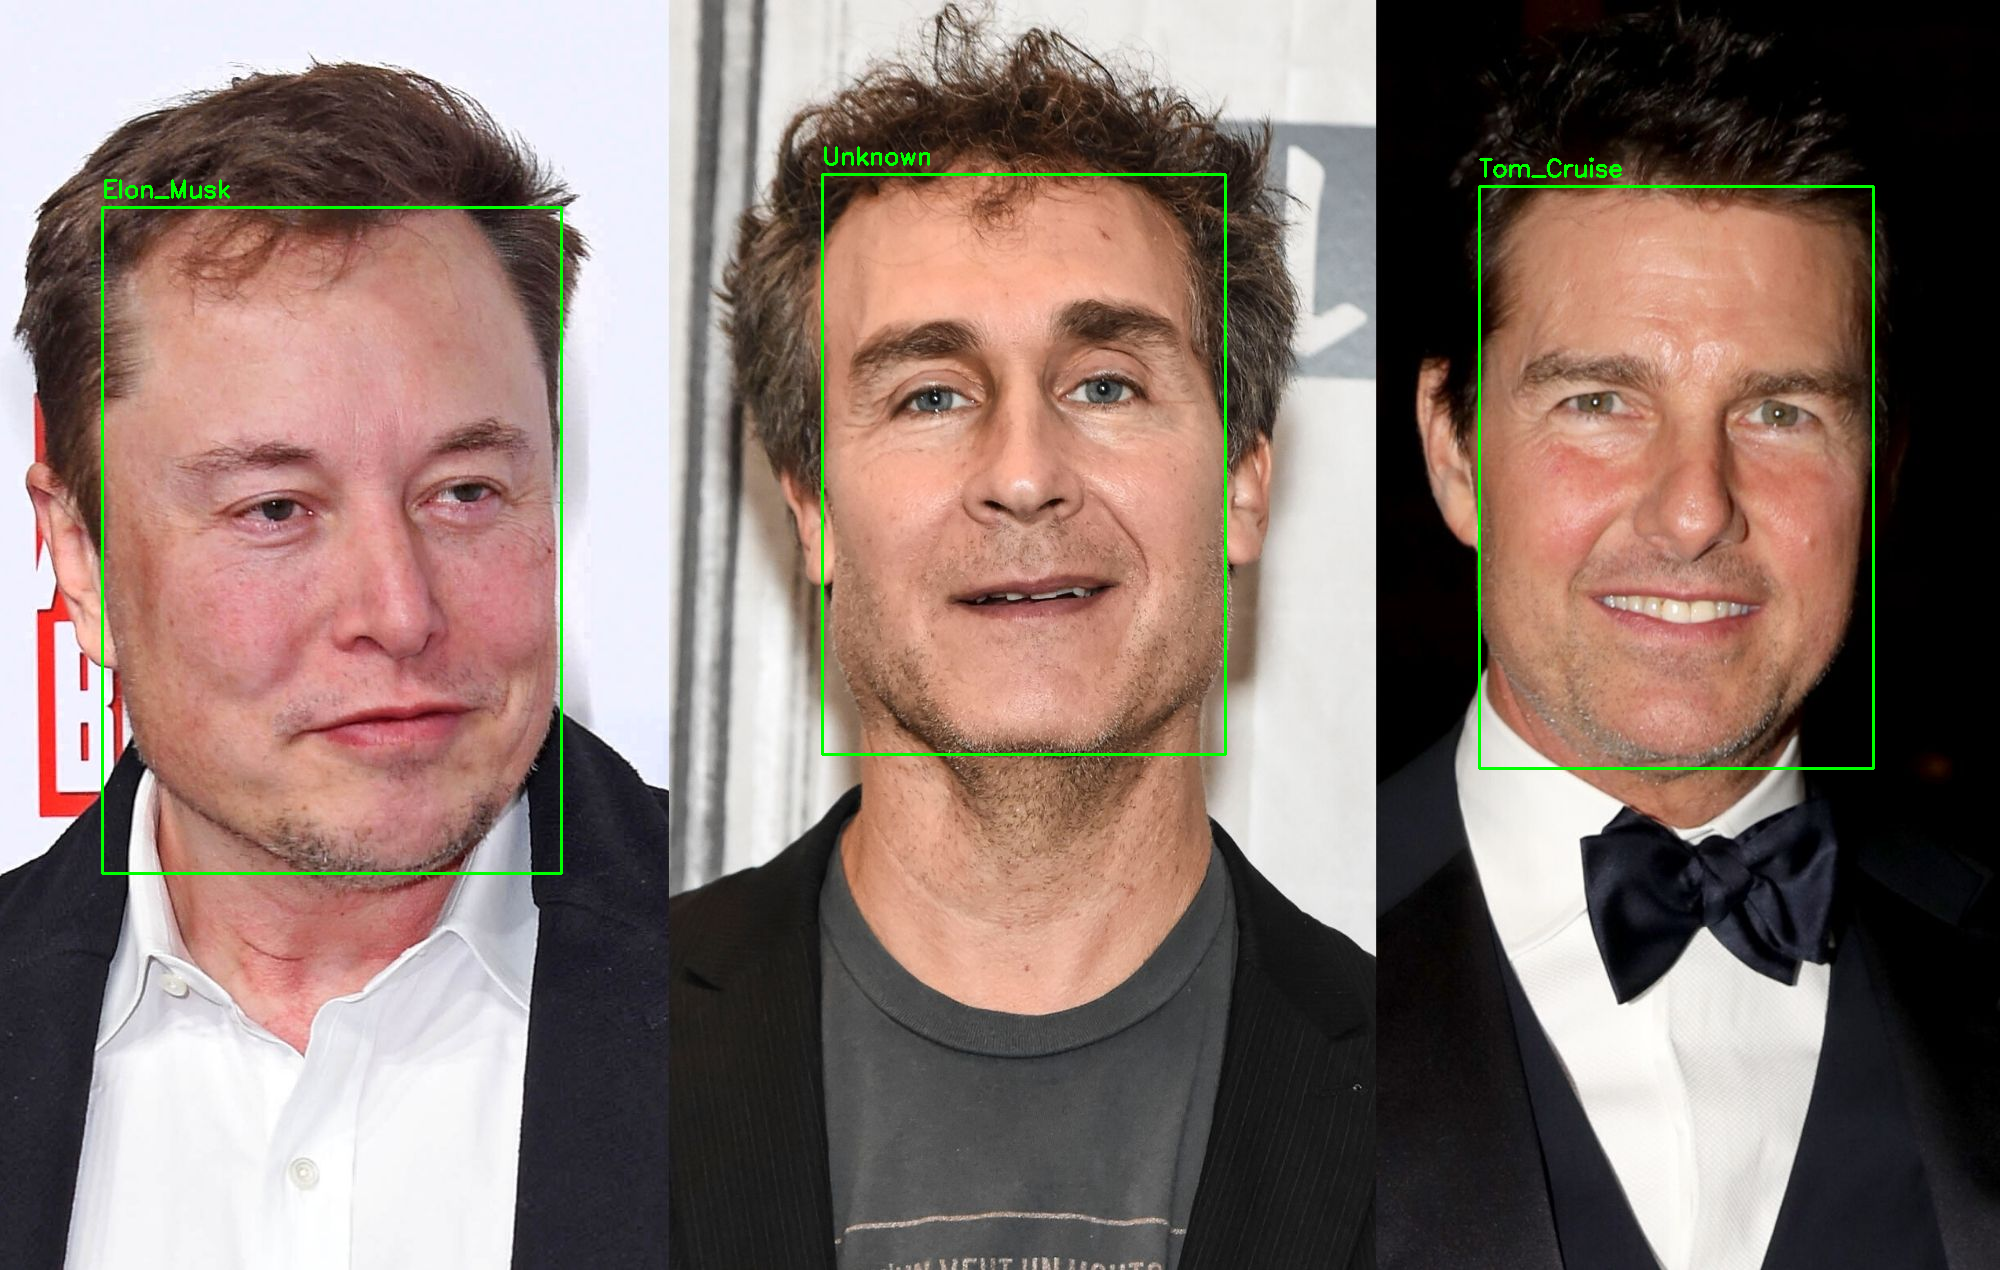

In [ ]:
import numpy as np
import cv2
from insightface.app import FaceAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from PIL import Image
import io

# Upload image from local system
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
print(f"📂 Selected file: {img_path}")

# Load test image
image = Image.open(io.BytesIO(uploaded[img_path]))
img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load saved face embeddings
load_path = '/content/drive/MyDrive/face_embeddings.npz'
data = np.load(load_path, allow_pickle=True)
known_embeddings = data['embeddings']
known_names = data['names']
print(f"✅ Loaded {len(known_names)} embeddings from disk.")

# Initialize face detection and recognition model
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0)

# Detect faces
faces = app.get(img_rgb)

# Process detected faces
for i, face in enumerate(faces):
    embedding = face['embedding'].reshape(1, -1)

    # Compare with known embeddings
    similarities = cosine_similarity(embedding, known_embeddings)[0]
    best_idx = np.argmax(similarities)
    best_score = similarities[best_idx]
    name = known_names[best_idx] if best_score > 0.5 else "Unknown"

    print(f"🧑 Face {i+1}: {name} (Similarity: {best_score:.2f})")

    # Draw result
    box = face['bbox'].astype(int)
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    cv2.putText(img, name, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

# Show the result image
from google.colab.patches import cv2_imshow
cv2_imshow(img)
